# Audio-based Depression Detection Model

In [ ]:

from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

from models.audio_rnn import AudioRNN
from preprocessing.loader_audio import AudioLoader
from preprocessing.loader_results import ResultsLoader
from training.trainer_audio_rnn import AudioRNNTrainer

# Constants
RANDOM_STATE = 42
DATA_PERCENTAGE = 0.02  # Percentage of total data to use
BATCH_SIZE = 32
N_EPOCHS = 50
FIGURE_SIZE = (15, 8)

# Hyperparameter grid for model tuning
PARAM_GRID = {
    'hidden_size': [64, 128],
    'num_layers': [1, 2],
    'dropout': [0.2, 0.3],
    'learning_rate': [0.001, 0.0001],
}

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


## Data Preparation

In [2]:
def load_data(percentage: float = DATA_PERCENTAGE, random_state: int = RANDOM_STATE) -> Tuple[
    pd.DataFrame, pd.DataFrame]:
    #Load and prepare the audio data and depression labels.
    # Initialize loaders
    results_loader = ResultsLoader()
    audio_loader = AudioLoader()

    # Load data
    df_result = results_loader.get_data(percentage=percentage, random_state=random_state)
    df_audio = audio_loader.get_data(
        percentage=percentage,
        random_state=random_state,
        ds_freq="10s",
        rw_size="10s"
    )

    return df_audio, df_result


# Load the data
df_audio, df_result = load_data()

# Display data 
print("Audio Features:")
display(df_audio.head())
print("\nReslutls:")
display(df_result.head())

Audio Features:


AUDIO_AMPLITUDE  FORMANT_F1  FORMANT_F2  FORMANT_F3  \
ID  TIMESTAMP                                                              
386 0 days 00:00:00        -0.000048  616.206600  1571.05937  2554.39041   
    0 days 00:00:10        -0.000021  719.887378  1726.74306  2604.00720   
    0 days 00:00:20        -0.000019  612.623780  1657.20697  2569.88200   
    0 days 00:00:30        -0.000018  536.712790  1657.41013  2599.18730   
    0 days 00:00:40        -0.000022  470.127492  1633.53475  2605.33350   

                     FORMANT_F4  FORMANT_F5  COVAREP_F0  COVAREP_VUV  \
ID  TIMESTAMP                                                          
386 0 days 00:00:00   3445.9205   4352.0802  245.137862     0.135864   
    0 days 00:00:10   3483.4309   4403.4083  250.681000     0.045000   
    0 days 00:00:20   3456.0944   4344.0295  248.715000     0.447000   
    0 days 00:00:30   3511.1177   4367.7521  234.705000     0.432000   
    0 days 00:00:40   3511.1365   4338.1031  220.724000     0.512000   

                     COVAREP_NAQ  COVAREP_QOQ  ...  COVAREP_HMPDD_3  \
ID  TIMESTAMP                                  ...                    
386 0 days 00:00:00     0.056730     0.149584  ...        -1.062799   
    0 days 00:00:10     0.042286     0.104357  ...        -1.052954   
    0 days 00:00:20     0.057813     0.177422  ...        -1.153109   
    0 days 00:00:30     0.057716     0.172310  ...        -1.110354   
    0 days 00:00:40     0.062179     0.199344  ...        -1.129166   

                     COVAREP_HMPDD_4  COVAREP_HMPDD_5  COVAREP_HMPDD_6  \
ID  TIMESTAMP                                                            
386 0 days 00:00:00        -0.910910        -0.758521        -0.613507   
    0 days 00:00:10        -0.925207        -0.766942        -0.607204   
    0 days 00:00:20        -0.958462        -0.744294        -0.547146   
    0 days 00:00:30        -0.951042        -0.752529        -0.588987   
    0 days 00:00:40        -0.958056        -0.773425        -0.608138   

                     COVAREP_HMPDD_7  COVAREP_HMPDD_8  COVAREP_HMPDD_9  \
ID  TIMESTAMP                                                            
386 0 days 00:00:00        -0.478457        -0.375517        -0.274640   
    0 days 00:00:10        -0.481018        -0.377985        -0.286668   
    0 days 00:00:20        -0.379929        -0.244665        -0.128930   
    0 days 00:00:30        -0.437365        -0.304667        -0.201107   
    0 days 00:00:40        -0.461581        -0.311399        -0.188094   

                     COVAREP_HMPDD_10  COVAREP_HMPDD_11  COVAREP_HMPDD_12  
ID  TIMESTAMP                                                              
386 0 days 00:00:00         -0.181269         -0.112634         -0.051552  
    0 days 00:00:10         -0.210696         -0.138245         -0.087930  
    0 days 00:00:20         -0.052521         -0.002873          0.032831  
    0 days 00:00:30         -0.129641         -0.062379         -0.012266  
    0 days 00:00:40         -0.109726         -0.051157          0.013474  

[5 rows x 80 columns]


Reslutls:


,PHQ_Binary
ID,
386,1
391,0


## Exploratory Data Analysis

Basic statistics for audio features:
       AUDIO_AMPLITUDE  FORMANT_F1   FORMANT_F2   FORMANT_F3   FORMANT_F4  \
count       173.000000  173.000000   173.000000   173.000000   173.000000   
mean         -0.000023  600.266186  1609.055183  2544.109598  3447.162709   
std           0.000011   58.174058    48.917096    47.323767    42.927462   
min          -0.000094  379.650000  1449.308980  2329.221780  3227.772300   
25%          -0.000027  567.147970  1578.039940  2513.867100  3420.798600   
50%          -0.000023  594.918430  1607.529560  2548.410700  3445.920500   
75%          -0.000019  628.113565  1639.191450  2573.139050  3476.711000   
max           0.000049  830.118787  1782.559460  2657.385000  3543.544200   

        FORMANT_F5  COVAREP_F0  COVAREP_VUV  COVAREP_NAQ  COVAREP_QOQ  ...  \
count   173.000000  173.000000   173.000000   173.000000   173.000000  ...   
mean   4324.200332  226.605150     0.428758     0.058391     0.191678  ...   
std      48.102999   23.582975     

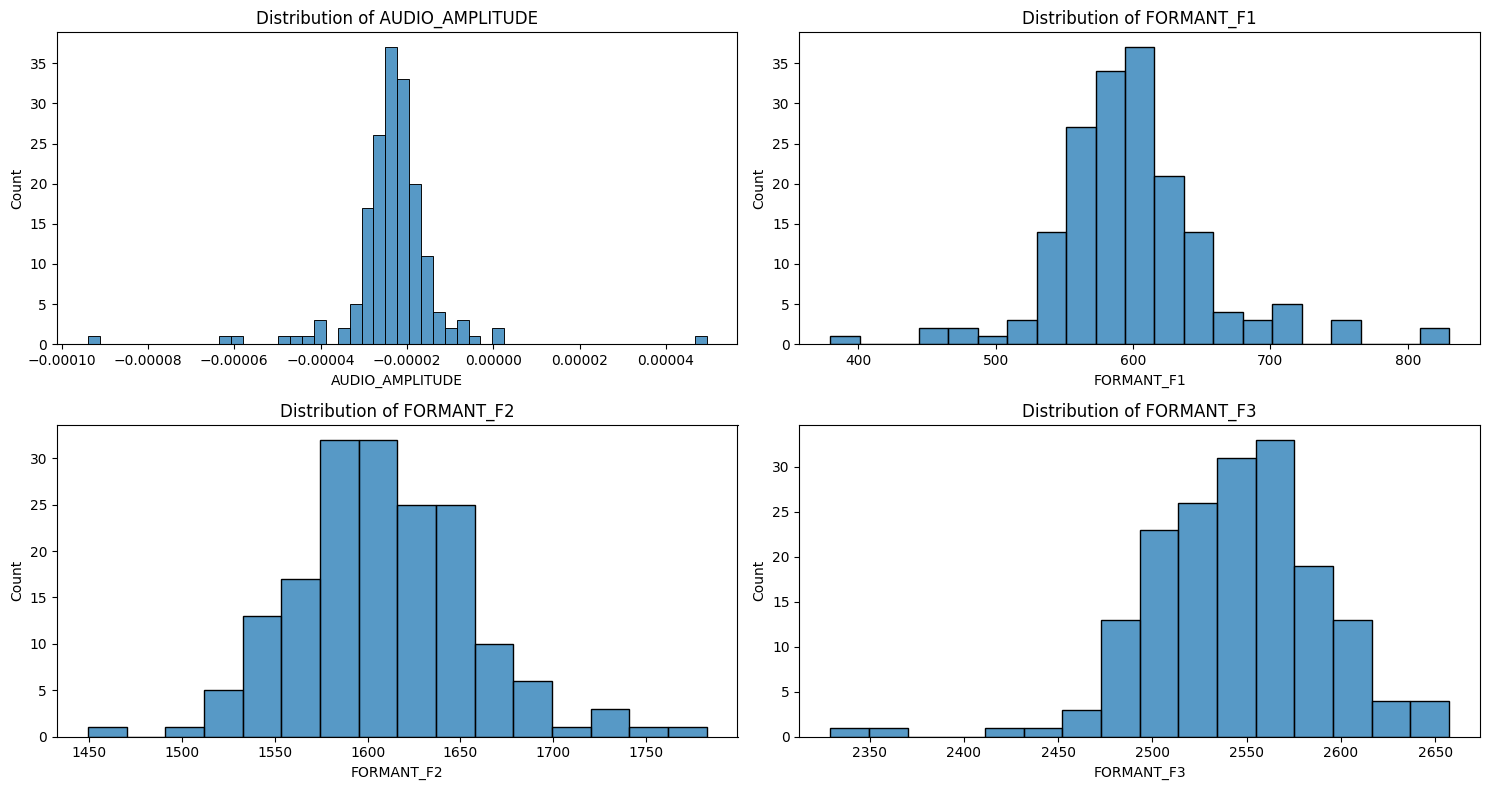

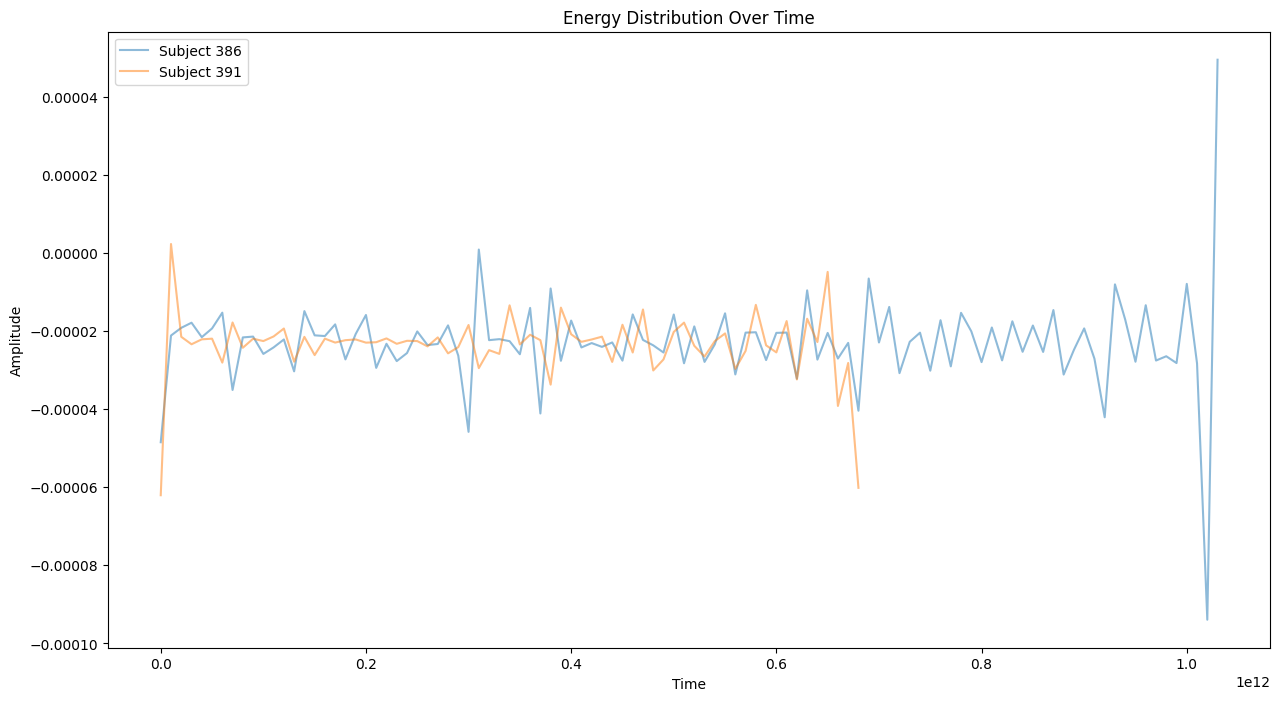

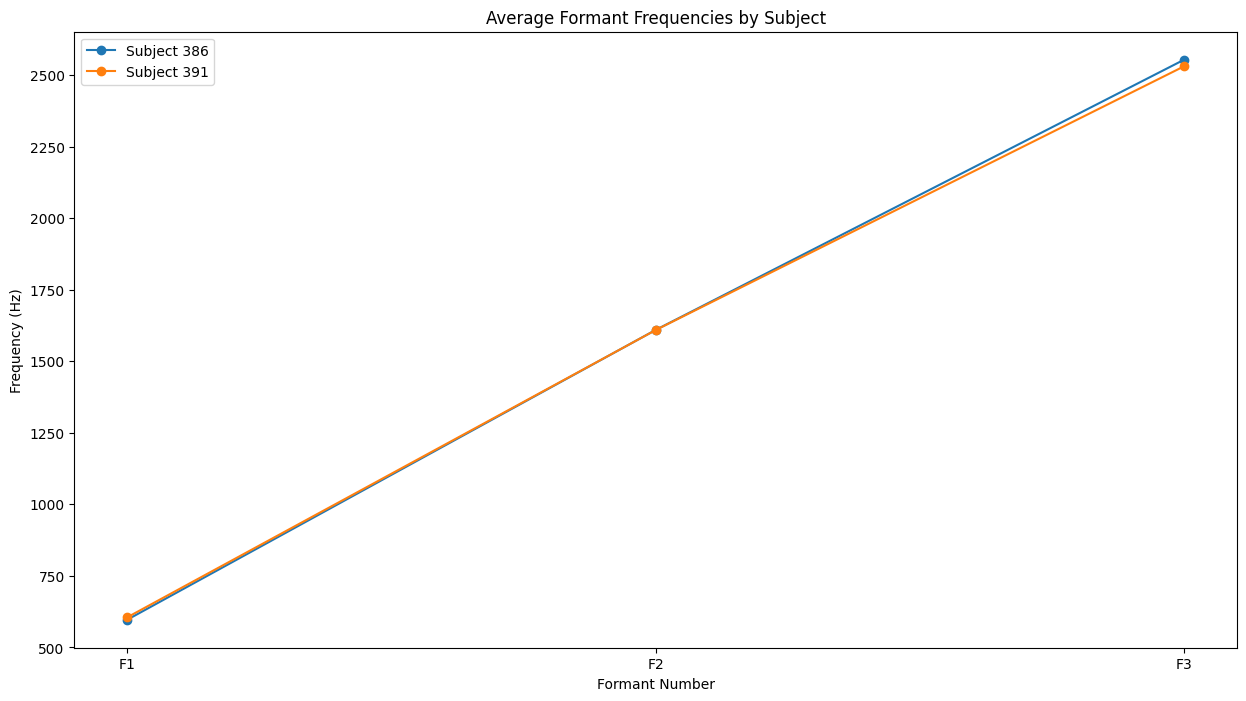

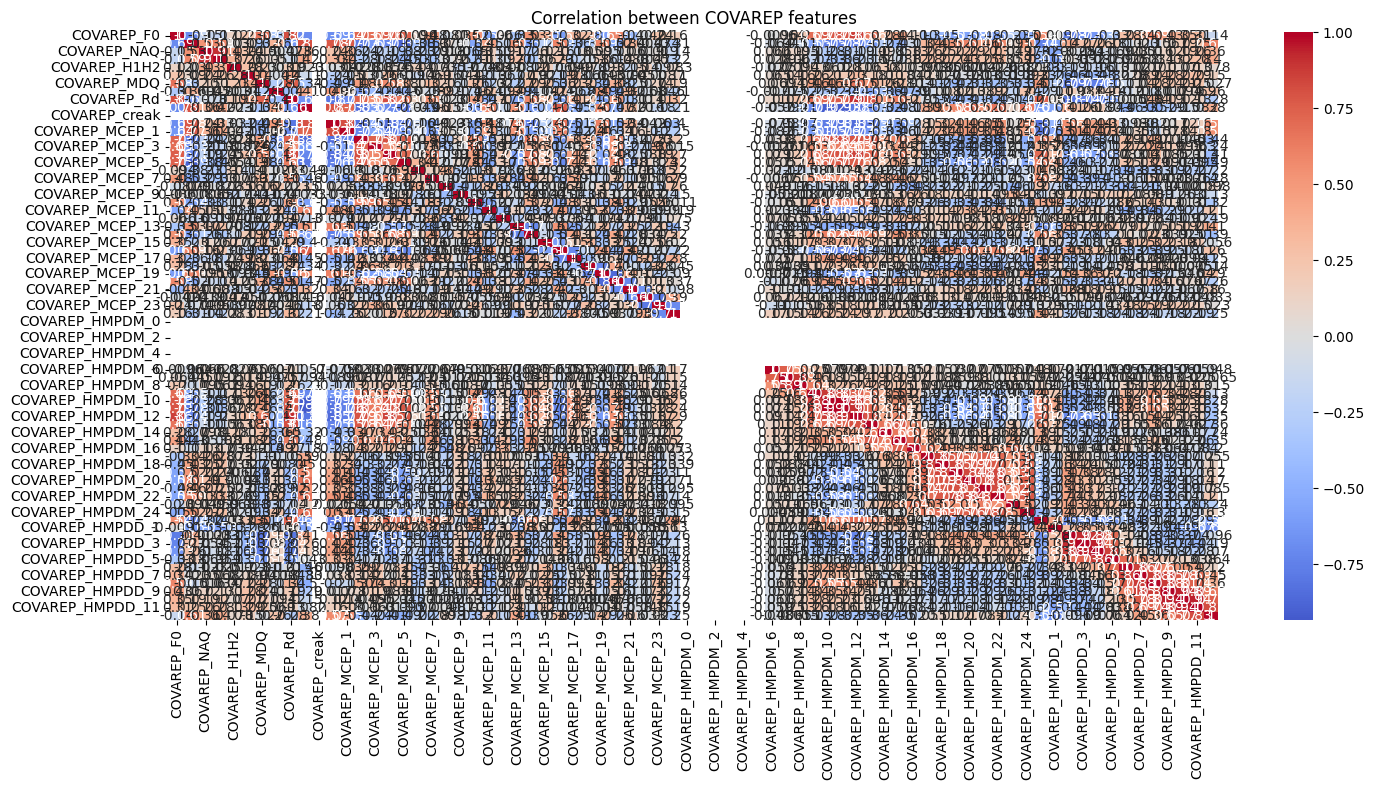

Subject 386 approximate speech activity rate: 0.0288
Subject 391 approximate speech activity rate: 0.0290


In [3]:
def plot_feature_distributions(df: pd.DataFrame, features: List[str], fig_size: Tuple[int, int] = FIGURE_SIZE):
    #Plot distributions of specified features.
    # for plotting distributions of key audio features (provided as a param for flexibility)

    n_features = len(features)
    n_cols = min(2, n_features)
    n_rows = (n_features + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    axes = axes.ravel()

    for idx, feature in enumerate(features):
        sns.histplot(data=df[feature], ax=axes[idx])
        axes[idx].set_title(f'Distribution of {feature}')
        axes[idx].set_xlabel(feature)

    plt.tight_layout()
    plt.show()


def plot_energy_distribution(df: pd.DataFrame, fig_size: Tuple[int, int] = FIGURE_SIZE):
    #Plot energy distribution over time for each subject.
    plt.figure(figsize=fig_size)
    for id in df.index.get_level_values('ID').unique():
        plt.plot(df.loc[id]['AUDIO_AMPLITUDE'],
                 alpha=0.5,
                 label=f'Subject {id}')
    plt.title('Energy Distribution Over Time')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()


def plot_formant_frequencies(df: pd.DataFrame, fig_size: Tuple[int, int] = FIGURE_SIZE):
    #Plot average formant frequencies by subject.
    plt.figure(figsize=fig_size)
    formant_features = ['FORMANT_F1', 'FORMANT_F2', 'FORMANT_F3']

    for id in df.index.get_level_values('ID').unique():
        subject_data = df.loc[id][formant_features]
        plt.plot(subject_data.mean(), 'o-', label=f'Subject {id}')

    plt.title('Average Formant Frequencies by Subject')
    plt.xlabel('Formant Number')
    plt.ylabel('Frequency (Hz)')
    plt.xticks([0, 1, 2], ['F1', 'F2', 'F3'])
    plt.legend()
    plt.show()


# Basic statistics
print("Basic statistics for audio features:")
print(df_audio.describe())

# Plot distributions of key audio features
audio_features = ['AUDIO_AMPLITUDE', 'FORMANT_F1', 'FORMANT_F2', 'FORMANT_F3']
plot_feature_distributions(df_audio, audio_features)

# Energy distribution over time
plot_energy_distribution(df_audio)

# Formant frequencies analysis
plot_formant_frequencies(df_audio)

# COVAREP features analysis
covarep_cols = [col for col in df_audio.columns if 'COVAREP' in col]
if covarep_cols:
    plt.figure(figsize=FIGURE_SIZE)
    sns.heatmap(df_audio[covarep_cols].corr(),
                annot=True,
                cmap='coolwarm',
                center=0)
    plt.title('Correlation between COVAREP features')
    plt.tight_layout()
    plt.show()

# Speech rate analysis (using amplitude changes as proxy)
for id in df_audio.index.get_level_values('ID').unique():
    subject_data = df_audio.loc[id]['AUDIO_AMPLITUDE']
    # Calculate zero crossings as a rough measure of speech activity
    zero_crossings = np.where(np.diff(np.signbit(subject_data)))[0]
    speech_rate = len(zero_crossings) / len(subject_data)
    print(f"Subject {id} approximate speech activity rate: {speech_rate:.4f}")


## Principal Component Analysis

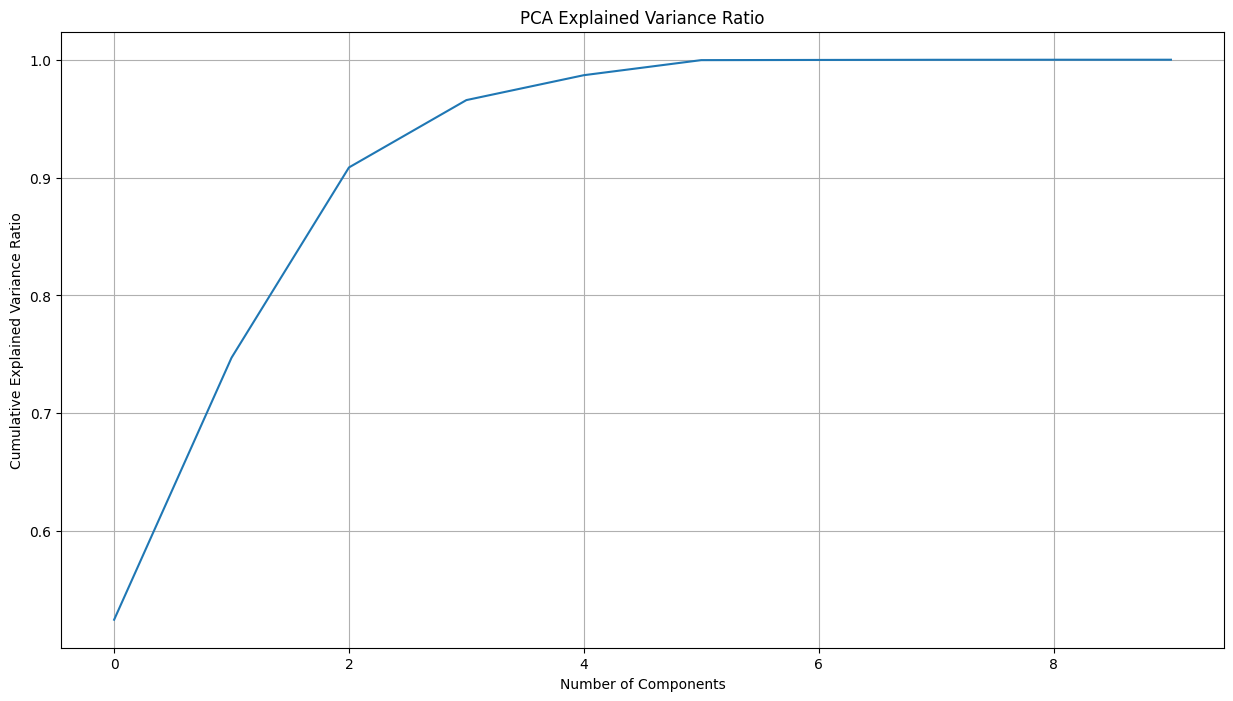

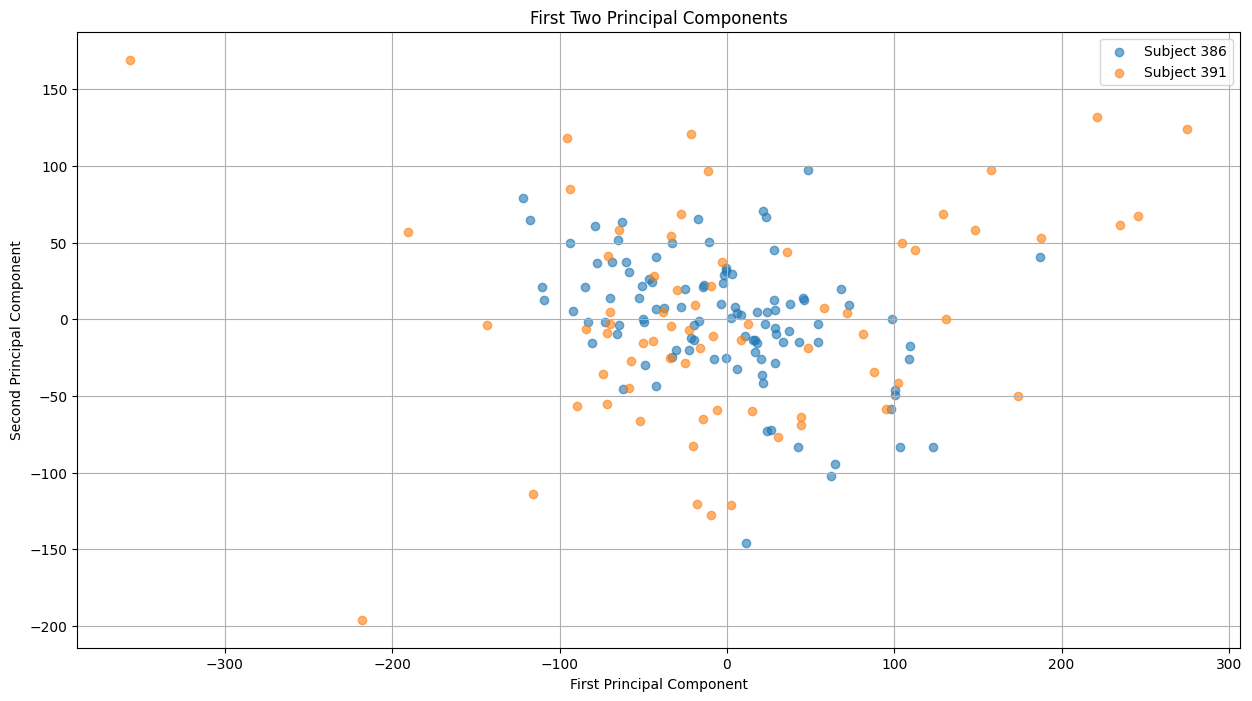


Explained variance ratio for each component:
PC1: 0.5249
PC2: 0.2223
PC3: 0.1614
PC4: 0.0571
PC5: 0.0211
PC6: 0.0128
PC7: 0.0002
PC8: 0.0001
PC9: 0.0000
PC10: 0.0000

Cumulative explained variance ratio:
[0.52491301 0.74717032 0.90855639 0.96569352 0.98680786 0.99959181
 0.9997476  0.99987461 0.99991956 0.99993361]


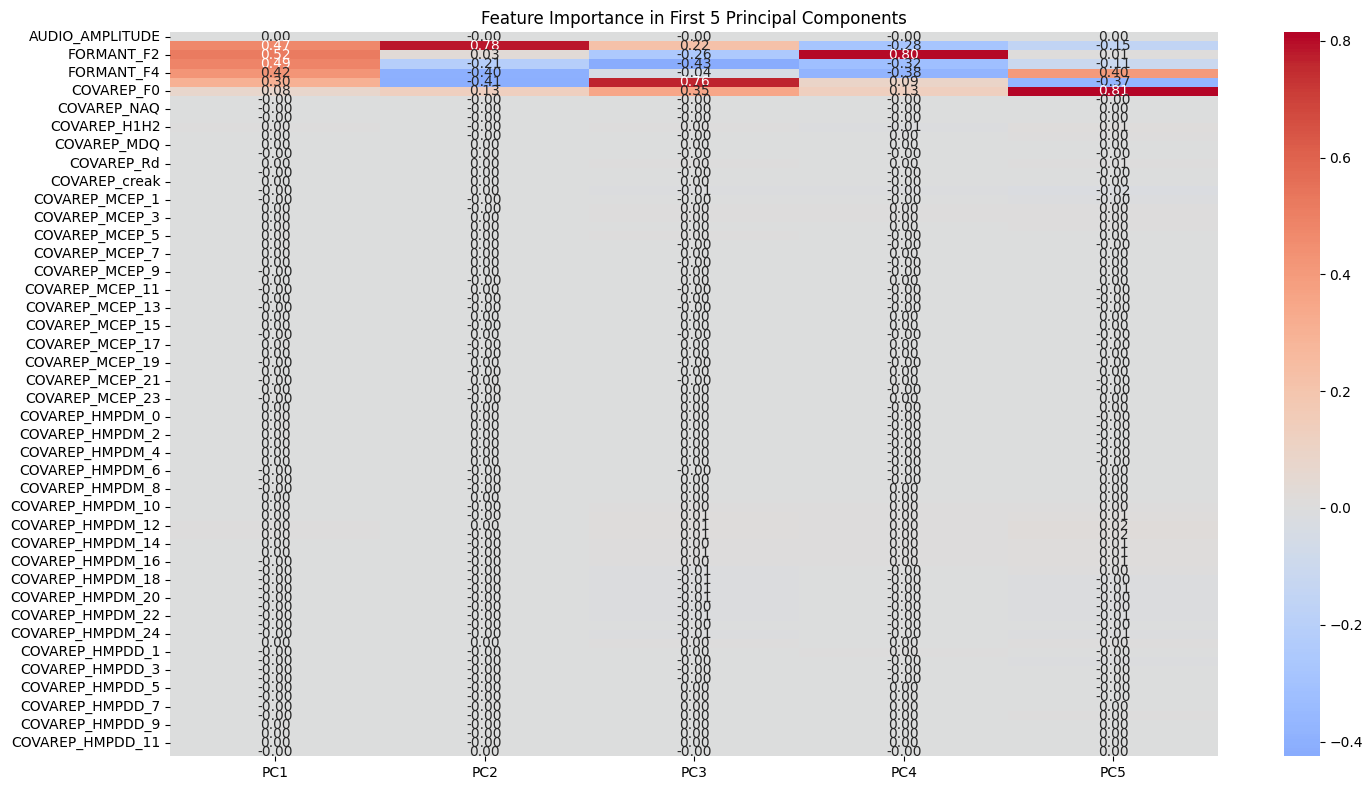

In [4]:
from sklearn.decomposition import PCA
from utils.pca_utils import save_pca_components


def perform_pca(df: pd.DataFrame, n_components: int = 10) -> Tuple[pd.DataFrame, pd.DataFrame, PCA]:
    #Perform PCA on the input data.
    # Select numerical features
    feature_data = df.select_dtypes(include=['float64', 'int64'])

    # Initialize and fit PCA
    pca = PCA(n_components=n_components)  # adjust n_components 
    feature_pca = pca.fit_transform(feature_data)
    
    # Determine the most important features for the first principal component
    abs_loadings = np.abs(pca.components_[0])
    sorted_indices = np.argsort(abs_loadings)[::-1]
    feature_names = [feature_data.columns[i] for i in sorted_indices[:n_components]] 

    # Save PCA components
    save_pca_components(
        pca=pca,
        feature_names=feature_names,
        output_path='models/pca_audio.pkl'
    )
    
    # Create DataFrame with PCA results
    pca_df = pd.DataFrame(
        feature_pca,
        columns=[f'PC{i + 1}' for i in range(feature_pca.shape[1])],
        index=feature_data.index
    )
    
    # Get feature importance
    feature_importance = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i + 1}' for i in range(feature_pca.shape[1])],
        index=feature_data.columns
    )

    return pca_df, feature_importance, pca


# Perform PCA
pca_df, feature_importance, pca = perform_pca(df_audio) # NOTE: by default the PCA will cut it down to 10 features. you can change that by setting n_components

# Plot explained variance ratio
plt.figure(figsize=FIGURE_SIZE)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.grid(True)
plt.show()

# Plot first two principal components
plt.figure(figsize=FIGURE_SIZE)
for id in pca_df.index.get_level_values('ID').unique():
    mask = pca_df.index.get_level_values('ID') == id
    plt.scatter(pca_df[mask]['PC1'],
                pca_df[mask]['PC2'],
                alpha=0.6,
                label=f'Subject {id}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('First Two Principal Components')
plt.legend()
plt.grid(True)
plt.show()

# Print explained variance ratios
print("\nExplained variance ratio for each component:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i + 1}: {ratio:.4f}")

# Print Cumulative explained variance ratio
print("\nCumulative explained variance ratio:")
print(np.cumsum(pca.explained_variance_ratio_))

# Plot heatmap of feature importance for first few components
plt.figure(figsize=FIGURE_SIZE)
sns.heatmap(feature_importance.iloc[:, :5],
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f')
plt.title('Feature Importance in First 5 Principal Components')
plt.tight_layout()
plt.show()

## Data Splitting

In [5]:
def prepare_data_splits(df_audio: pd.DataFrame, df_result: pd.DataFrame) -> Tuple[
    np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    #Prepare data splits for training, validation, and testing.
    # Merge audio features with depression labels
    df = pd.merge(df_audio, df_result, on='ID')  

    # Prepare features and target
    X = df.drop(['PHQ_Binary'], axis=1)
    y = df['PHQ_Binary']

    # Create time series split
    tscv = TimeSeriesSplit(n_splits=5)
    train_indices = []
    test_indices = []

    # Get split indices while preserving temporal order
    for train_idx, test_idx in tscv.split(X):
        train_indices.append(train_idx)
        test_indices.append(test_idx)

    # Use the last fold for final train/test split
    X_train = X.iloc[train_indices[-1]]
    X_test = X.iloc[test_indices[-1]]
    y_train = y.iloc[train_indices[-1]]
    y_test = y.iloc[test_indices[-1]]

    # Further split training data into train and validation
    train_size = int(0.75 * len(X_train))
    X_train, X_val = X_train.iloc[:train_size], X_train.iloc[train_size:]
    y_train, y_val = y_train.iloc[:train_size], y_train.iloc[train_size:]

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler


# Prepare data splits
X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data_splits(pca_df, df_result)



## Model Training

  0%|          | 0/16 [00:00<?, ?it/s]/Users/karlo/College/Diplomski/Code/multimodal_depression_detection/DepressionDetection/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Validation: 100%|██████████| 2/2 [00:00<00:00, 536.91it/s, loss=0.6222]


Epoch 1/50
Train Loss: 0.7645, Val Loss: 0.6249, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 589.79it/s, loss=0.6379]


Epoch 2/50
Train Loss: 0.7476, Val Loss: 0.6410, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 609.42it/s, loss=0.6542]


Epoch 3/50
Train Loss: 0.7281, Val Loss: 0.6581, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 255.92it/s, loss=0.6719]


Epoch 4/50
Train Loss: 0.7099, Val Loss: 0.6767, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 535.19it/s, loss=0.6908]


Epoch 5/50
Train Loss: 0.6899, Val Loss: 0.6969, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 520.55it/s, loss=0.6928]


Epoch 6/50
Train Loss: 0.6732, Val Loss: 0.6992, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 566.57it/s, loss=0.6949]


Epoch 7/50
Train Loss: 0.6728, Val Loss: 0.7014, LR: 0.000100


  6%|▋         | 1/16 [00:00<00:12,  1.23it/s]

Epoch 8/50
Train Loss: 0.6702, Val Loss: 0.7038, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 409.66it/s, loss=0.8021]


Epoch 1/50
Train Loss: 0.6139, Val Loss: 0.8020, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 742.68it/s, loss=0.8260]


Epoch 2/50
Train Loss: 0.6025, Val Loss: 0.8253, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 649.32it/s, loss=0.8502]


Epoch 3/50
Train Loss: 0.5783, Val Loss: 0.8489, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 640.25it/s, loss=0.8730]


Epoch 4/50
Train Loss: 0.5640, Val Loss: 0.8715, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 588.72it/s, loss=0.8976]


Epoch 5/50
Train Loss: 0.5527, Val Loss: 0.8954, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 531.90it/s, loss=0.9002]


Epoch 6/50
Train Loss: 0.5413, Val Loss: 0.8979, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 543.34it/s, loss=0.9028]


Epoch 7/50
Train Loss: 0.5407, Val Loss: 0.9004, LR: 0.000100


 12%|█▎        | 2/16 [00:01<00:06,  2.11it/s]

Epoch 8/50
Train Loss: 0.5407, Val Loss: 0.9029, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 588.80it/s, loss=0.7325]


Epoch 1/50
Train Loss: 0.6476, Val Loss: 0.7391, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 658.14it/s, loss=0.7346]


Epoch 2/50
Train Loss: 0.6460, Val Loss: 0.7411, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 538.66it/s, loss=0.7367]


Epoch 3/50
Train Loss: 0.6442, Val Loss: 0.7432, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 560.85it/s, loss=0.7386]


Epoch 4/50
Train Loss: 0.6429, Val Loss: 0.7451, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 375.80it/s, loss=0.7405]


Epoch 5/50
Train Loss: 0.6406, Val Loss: 0.7470, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 625.78it/s, loss=0.7407]


Epoch 6/50
Train Loss: 0.6405, Val Loss: 0.7472, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 548.85it/s, loss=0.7409]


Epoch 7/50
Train Loss: 0.6439, Val Loss: 0.7474, LR: 0.000010


 19%|█▉        | 3/16 [00:01<00:04,  2.91it/s]

Epoch 8/50
Train Loss: 0.6414, Val Loss: 0.7476, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 585.51it/s, loss=0.5837]


Epoch 1/50
Train Loss: 0.8113, Val Loss: 0.5834, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 545.71it/s, loss=0.5852]


Epoch 2/50
Train Loss: 0.8102, Val Loss: 0.5850, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 556.98it/s, loss=0.5868]


Epoch 3/50
Train Loss: 0.8063, Val Loss: 0.5866, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 233.45it/s, loss=0.5884]


Epoch 4/50
Train Loss: 0.8064, Val Loss: 0.5882, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 400.24it/s, loss=0.5901]


Epoch 5/50
Train Loss: 0.8023, Val Loss: 0.5899, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 474.01it/s, loss=0.5902]


Epoch 6/50
Train Loss: 0.8025, Val Loss: 0.5901, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 584.78it/s, loss=0.5904]


Epoch 7/50
Train Loss: 0.8005, Val Loss: 0.5902, LR: 0.000010


 25%|██▌       | 4/16 [00:01<00:03,  3.46it/s]

Epoch 8/50
Train Loss: 0.8024, Val Loss: 0.5904, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 572.09it/s, loss=0.7830]


Epoch 1/50
Train Loss: 0.6281, Val Loss: 0.7850, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 409.42it/s, loss=0.8093]


Epoch 2/50
Train Loss: 0.6069, Val Loss: 0.8128, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 423.03it/s, loss=0.8377]


Epoch 3/50
Train Loss: 0.5822, Val Loss: 0.8428, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 327.49it/s, loss=0.8707]


Epoch 4/50
Train Loss: 0.5600, Val Loss: 0.8772, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 502.04it/s, loss=0.9083]


Epoch 5/50
Train Loss: 0.5343, Val Loss: 0.9163, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 434.31it/s, loss=0.9128]


Epoch 6/50
Train Loss: 0.5175, Val Loss: 0.9209, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 508.09it/s, loss=0.9173]


Epoch 7/50
Train Loss: 0.5116, Val Loss: 0.9255, LR: 0.000100


 31%|███▏      | 5/16 [00:01<00:02,  3.83it/s]

Epoch 8/50
Train Loss: 0.5148, Val Loss: 0.9302, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 448.16it/s, loss=0.7821]


Epoch 1/50
Train Loss: 0.6331, Val Loss: 0.7819, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 508.00it/s, loss=0.8176]


Epoch 2/50
Train Loss: 0.6072, Val Loss: 0.8174, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 261.03it/s, loss=0.8567]


Epoch 3/50
Train Loss: 0.5834, Val Loss: 0.8569, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 345.41it/s, loss=0.9069]


Epoch 4/50
Train Loss: 0.5474, Val Loss: 0.9075, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 465.98it/s, loss=0.9767]


Epoch 5/50
Train Loss: 0.5083, Val Loss: 0.9782, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 484.25it/s, loss=0.9852]


Epoch 6/50
Train Loss: 0.4815, Val Loss: 0.9870, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 453.81it/s, loss=0.9944]


Epoch 7/50
Train Loss: 0.4802, Val Loss: 0.9963, LR: 0.000100


 38%|███▊      | 6/16 [00:01<00:02,  3.79it/s]

Epoch 8/50
Train Loss: 0.4798, Val Loss: 1.0061, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 668.73it/s, loss=0.6248]


Epoch 1/50
Train Loss: 0.7602, Val Loss: 0.6225, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 184.06it/s, loss=0.6271]


Epoch 2/50
Train Loss: 0.7555, Val Loss: 0.6249, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 371.95it/s, loss=0.6295]


Epoch 3/50
Train Loss: 0.7484, Val Loss: 0.6273, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 568.83it/s, loss=0.6319]


Epoch 4/50
Train Loss: 0.7452, Val Loss: 0.6297, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 526.72it/s, loss=0.6342]


Epoch 5/50
Train Loss: 0.7459, Val Loss: 0.6321, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 466.76it/s, loss=0.6344]


Epoch 6/50
Train Loss: 0.7453, Val Loss: 0.6323, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 559.88it/s, loss=0.6346]


Epoch 7/50
Train Loss: 0.7444, Val Loss: 0.6326, LR: 0.000010


 44%|████▍     | 7/16 [00:02<00:02,  4.11it/s]

Epoch 8/50
Train Loss: 0.7444, Val Loss: 0.6328, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 451.24it/s, loss=0.6806]


Epoch 1/50
Train Loss: 0.7067, Val Loss: 0.6812, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 421.39it/s, loss=0.6839]


Epoch 2/50
Train Loss: 0.7041, Val Loss: 0.6845, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 427.92it/s, loss=0.6872]


Epoch 3/50
Train Loss: 0.7013, Val Loss: 0.6878, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 454.25it/s, loss=0.6905]


Epoch 4/50
Train Loss: 0.6987, Val Loss: 0.6912, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 405.34it/s, loss=0.6938]


Epoch 5/50
Train Loss: 0.6937, Val Loss: 0.6945, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 479.16it/s, loss=0.6942]


Epoch 6/50
Train Loss: 0.6924, Val Loss: 0.6949, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 471.56it/s, loss=0.6945]


Epoch 7/50
Train Loss: 0.6910, Val Loss: 0.6952, LR: 0.000010


 50%|█████     | 8/16 [00:02<00:01,  4.01it/s]

Epoch 8/50
Train Loss: 0.6924, Val Loss: 0.6956, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 271.03it/s, loss=0.8446]


Epoch 1/50
Train Loss: 0.5900, Val Loss: 0.8407, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 600.43it/s, loss=0.8611]


Epoch 2/50
Train Loss: 0.5668, Val Loss: 0.8584, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 611.06it/s, loss=0.8786]


Epoch 3/50
Train Loss: 0.5577, Val Loss: 0.8769, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 681.67it/s, loss=0.8964]


Epoch 4/50
Train Loss: 0.5383, Val Loss: 0.8957, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 589.29it/s, loss=0.9157]


Epoch 5/50
Train Loss: 0.5252, Val Loss: 0.9162, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 562.62it/s, loss=0.9176]


Epoch 6/50
Train Loss: 0.5192, Val Loss: 0.9183, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 123.89it/s, loss=0.9197]


Epoch 7/50
Train Loss: 0.5166, Val Loss: 0.9205, LR: 0.000100


 56%|█████▋    | 9/16 [00:02<00:01,  4.13it/s]

Epoch 8/50
Train Loss: 0.5072, Val Loss: 0.9227, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 602.93it/s, loss=0.6979]


Epoch 1/50
Train Loss: 0.7029, Val Loss: 0.6977, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 645.82it/s, loss=0.7217]


Epoch 2/50
Train Loss: 0.6797, Val Loss: 0.7215, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 559.88it/s, loss=0.7473]


Epoch 3/50
Train Loss: 0.6583, Val Loss: 0.7470, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 502.64it/s, loss=0.7762]


Epoch 4/50
Train Loss: 0.6339, Val Loss: 0.7757, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 564.21it/s, loss=0.8096]


Epoch 5/50
Train Loss: 0.6122, Val Loss: 0.8091, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 307.69it/s, loss=0.8133]


Epoch 6/50
Train Loss: 0.5923, Val Loss: 0.8127, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 601.33it/s, loss=0.8171]


Epoch 7/50
Train Loss: 0.5921, Val Loss: 0.8165, LR: 0.000100


 62%|██████▎   | 10/16 [00:02<00:01,  4.34it/s]

Epoch 8/50
Train Loss: 0.5881, Val Loss: 0.8204, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 594.39it/s, loss=0.7105]


Epoch 1/50
Train Loss: 0.6887, Val Loss: 0.7116, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 624.99it/s, loss=0.7118]


Epoch 2/50
Train Loss: 0.6891, Val Loss: 0.7130, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 566.42it/s, loss=0.7131]


Epoch 3/50
Train Loss: 0.6852, Val Loss: 0.7144, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 666.40it/s, loss=0.7145]


Epoch 4/50
Train Loss: 0.6835, Val Loss: 0.7158, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 664.02it/s, loss=0.7159]


Epoch 5/50
Train Loss: 0.6818, Val Loss: 0.7172, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 263.44it/s, loss=0.7160]


Epoch 6/50
Train Loss: 0.6823, Val Loss: 0.7174, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 570.46it/s, loss=0.7162]


Epoch 7/50
Train Loss: 0.6832, Val Loss: 0.7175, LR: 0.000010


 69%|██████▉   | 11/16 [00:02<00:01,  4.65it/s]

Epoch 8/50
Train Loss: 0.6824, Val Loss: 0.7177, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 657.47it/s, loss=0.7432]


Epoch 1/50
Train Loss: 0.6496, Val Loss: 0.7435, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 679.07it/s, loss=0.7449]


Epoch 2/50
Train Loss: 0.6491, Val Loss: 0.7453, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 554.47it/s, loss=0.7467]


Epoch 3/50
Train Loss: 0.6475, Val Loss: 0.7471, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 524.39it/s, loss=0.7485]


Epoch 4/50
Train Loss: 0.6447, Val Loss: 0.7489, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 391.15it/s, loss=0.7503]

Epoch 5/50
Train Loss: 0.6430, Val Loss: 0.7506, LR: 0.000100



Validation: 100%|██████████| 2/2 [00:00<00:00, 429.48it/s, loss=0.7504]


Epoch 6/50
Train Loss: 0.6410, Val Loss: 0.7508, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 590.17it/s, loss=0.7506]


Epoch 7/50
Train Loss: 0.6450, Val Loss: 0.7510, LR: 0.000010


 75%|███████▌  | 12/16 [00:03<00:00,  4.71it/s]

Epoch 8/50
Train Loss: 0.6417, Val Loss: 0.7512, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 452.68it/s, loss=0.7662]


Epoch 1/50
Train Loss: 0.6451, Val Loss: 0.7689, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 550.36it/s, loss=0.7933]


Epoch 2/50
Train Loss: 0.6140, Val Loss: 0.7967, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 524.78it/s, loss=0.8234]


Epoch 3/50
Train Loss: 0.5894, Val Loss: 0.8277, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 578.05it/s, loss=0.8560]


Epoch 4/50
Train Loss: 0.5634, Val Loss: 0.8621, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 298.34it/s, loss=0.8944]


Epoch 5/50
Train Loss: 0.5274, Val Loss: 0.9019, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 534.78it/s, loss=0.8986]


Epoch 6/50
Train Loss: 0.5066, Val Loss: 0.9063, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 700.80it/s, loss=0.9032]


Epoch 7/50
Train Loss: 0.5054, Val Loss: 0.9110, LR: 0.000100


 81%|████████▏ | 13/16 [00:03<00:00,  4.74it/s]

Epoch 8/50
Train Loss: 0.5059, Val Loss: 0.9159, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 498.76it/s, loss=0.6582]


Epoch 1/50
Train Loss: 0.7424, Val Loss: 0.6581, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 394.39it/s, loss=0.6866]


Epoch 2/50
Train Loss: 0.7170, Val Loss: 0.6864, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 436.20it/s, loss=0.7217]


Epoch 3/50
Train Loss: 0.6881, Val Loss: 0.7214, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 345.55it/s, loss=0.7656]


Epoch 4/50
Train Loss: 0.6462, Val Loss: 0.7657, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 397.72it/s, loss=0.8189]


Epoch 5/50
Train Loss: 0.6053, Val Loss: 0.8202, LR: 0.001000


Validation: 100%|██████████| 2/2 [00:00<00:00, 435.91it/s, loss=0.8252]


Epoch 6/50
Train Loss: 0.5746, Val Loss: 0.8266, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 560.36it/s, loss=0.8317]


Epoch 7/50
Train Loss: 0.5747, Val Loss: 0.8334, LR: 0.000100


 88%|████████▊ | 14/16 [00:03<00:00,  4.46it/s]

Epoch 8/50
Train Loss: 0.5690, Val Loss: 0.8405, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 516.76it/s, loss=0.6323]


Epoch 1/50
Train Loss: 0.7540, Val Loss: 0.6320, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 451.15it/s, loss=0.6349]


Epoch 2/50
Train Loss: 0.7485, Val Loss: 0.6346, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 183.03it/s, loss=0.6375]


Epoch 3/50
Train Loss: 0.7468, Val Loss: 0.6373, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 411.93it/s, loss=0.6402]


Epoch 4/50
Train Loss: 0.7454, Val Loss: 0.6400, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 588.10it/s, loss=0.6429]


Epoch 5/50
Train Loss: 0.7395, Val Loss: 0.6427, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 509.42it/s, loss=0.6432]


Epoch 6/50
Train Loss: 0.7377, Val Loss: 0.6430, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 645.77it/s, loss=0.6435]


Epoch 7/50
Train Loss: 0.7409, Val Loss: 0.6432, LR: 0.000010


 94%|█████████▍| 15/16 [00:03<00:00,  4.56it/s]

Epoch 8/50
Train Loss: 0.7365, Val Loss: 0.6435, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 2/2 [00:00<00:00, 427.53it/s, loss=0.7523]


Epoch 1/50
Train Loss: 0.6443, Val Loss: 0.7525, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 470.27it/s, loss=0.7558]


Epoch 2/50
Train Loss: 0.6423, Val Loss: 0.7561, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 130.23it/s, loss=0.7593]


Epoch 3/50
Train Loss: 0.6378, Val Loss: 0.7595, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 417.45it/s, loss=0.7628]


Epoch 4/50
Train Loss: 0.6333, Val Loss: 0.7630, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 395.58it/s, loss=0.7662]


Epoch 5/50
Train Loss: 0.6314, Val Loss: 0.7665, LR: 0.000100


Validation: 100%|██████████| 2/2 [00:00<00:00, 431.78it/s, loss=0.7666]


Epoch 6/50
Train Loss: 0.6283, Val Loss: 0.7668, LR: 0.000010


Validation: 100%|██████████| 2/2 [00:00<00:00, 548.85it/s, loss=0.7669]


Epoch 7/50
Train Loss: 0.6287, Val Loss: 0.7672, LR: 0.000010


100%|██████████| 16/16 [00:04<00:00,  3.86it/s]


Epoch 8/50
Train Loss: 0.6279, Val Loss: 0.7675, LR: 0.000010
Early stopping triggered at epoch 8

Best parameters:
dropout: 0.2
hidden_size: 64
learning_rate: 0.0001
num_layers: 2


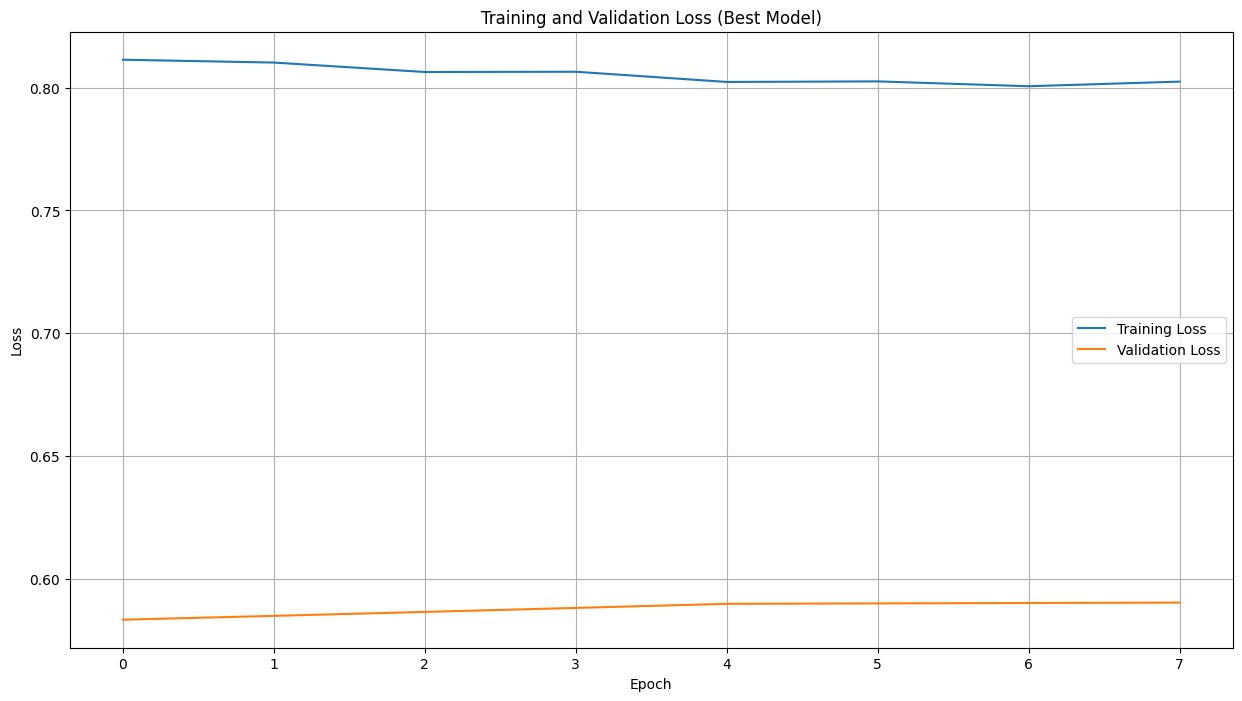

In [6]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


def create_data_loaders(X_train: np.ndarray, X_val: np.ndarray, X_test: np.ndarray,
                        y_train: np.ndarray, y_val: np.ndarray, y_test: np.ndarray,
                        batch_size: int = BATCH_SIZE) -> Tuple[DataLoader, DataLoader, DataLoader]:
    #Create PyTorch DataLoaders for training, validation, and testing.
    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_train_tensor = torch.LongTensor(y_train.values)
    y_val_tensor = torch.LongTensor(y_val.values)
    y_test_tensor = torch.LongTensor(y_test.values)

    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader


def train_model_with_grid_search(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray,
                                 param_grid: Dict, n_epochs: int = N_EPOCHS) -> Tuple[Dict, List[Dict]]:
    #Perform grid search to find optimal hyperparameters.
    # Create data loaders
    train_loader, val_loader, _ = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test)

    # Initialize tracking variables
    best_val_loss = float('inf')
    best_params = None
    results = []

    # Grid search
    for params in tqdm(ParameterGrid(param_grid)):
        # Model initialization
        model = AudioRNN(
            input_size=X_train.shape[1],
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        ).to(DEVICE)

        # Training setup
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.1,
            patience=3,
            verbose=True
        )

        # Initialize trainer
        trainer = AudioRNNTrainer(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            device=DEVICE
        )

        # Train model
        train_losses, val_losses = trainer.train(
            train_loader=train_loader,
            val_loader=val_loader,
            n_epochs=n_epochs
        )

        # Record results
        final_val_loss = val_losses[-1]
        results.append({
            'params': params,
            'final_val_loss': final_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses
        })

        # Update best parameters
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_params = params

    return best_params, results


# Train model with grid search
best_params, results = train_model_with_grid_search(X_train, y_train, X_val, y_val, PARAM_GRID) # TODO: set num of epochs as well

# Print best parameters
print("\nBest parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
# print(f"Best validation loss: {best_val_loss:.4f}")

# Plot training curves for best model
plt.figure(figsize=FIGURE_SIZE)
best_result = min(results, key=lambda x: x['final_val_loss'])
plt.plot(best_result['train_losses'], label='Training Loss')
plt.plot(best_result['val_losses'], label='Validation Loss')
plt.title('Training and Validation Loss (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


/Users/karlo/College/Diplomski/Code/multimodal_depression_detection/DepressionDetection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


<Figure size 1500x800 with 0 Axes>

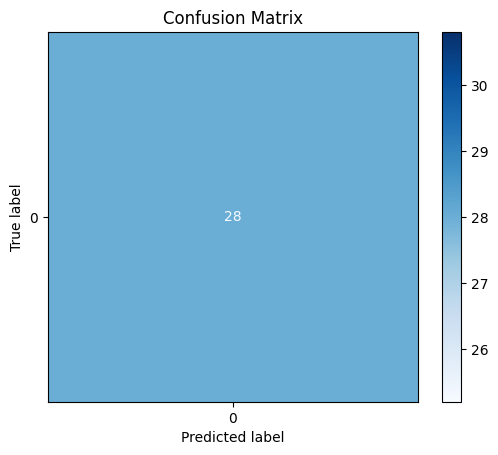

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


def evaluate_model(model: nn.Module, test_loader: DataLoader, device: torch.device) -> Tuple[np.ndarray, np.ndarray]:
    #Evaluate the model on the test set.
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


# Create test loader
_, _, test_loader = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test)

# Initialize best model
best_model = AudioRNN(
    input_size=X_train.shape[1],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
).to(DEVICE)

# Evaluate model
y_true, y_pred = evaluate_model(best_model, test_loader, DEVICE)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
plt.figure(figsize=FIGURE_SIZE)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Save Model

In [8]:
from training.trainer import save_model

# Save the model and scaler
save_model(best_model, scaler, X_train.shape[1], best_params, "audio_model.pth")
print("Model and scaler saved successfully!")

Model and scaler saved successfully!
